In [1]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = '&E}d~KiDvRmIUmZ>fd+h_TF*mg#:g~[<bPI<ix<E'
config = SHConfig()


if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
    

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [52]:
betsiboka_coords_wgs84 = [14.073486,45.893831,14.990845,46.305201]
resolution = 50
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 50 m resolution: (1423, 906) pixels


In [ ]:
for collection in DataCollection.get_available_collections():
    print(collection)
    

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (906, 1423, 3)
Image type: uint8


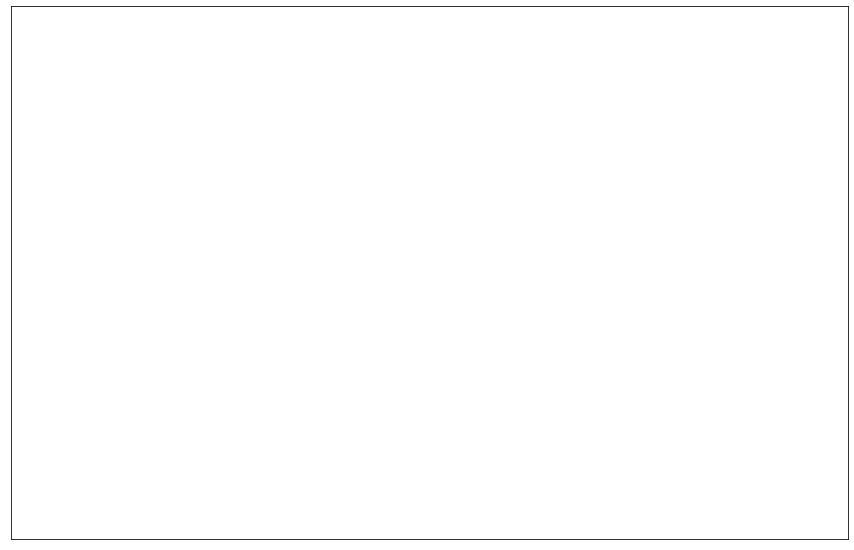

In [65]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-06-08', '2020-06-10'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)
true_color_imgs = request_true_color.get_data()
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

[[1168.1216  1168.1216  1202.5902  ...  674.3791   699.6838   708.3512 ]
 [1177.3414  1177.3414  1200.291   ...  678.566    694.9901   705.52637]
 [1177.3414  1177.3414  1200.291   ...  678.566    694.9901   705.52637]
 ...
 [1180.2278  1180.2278  1160.018   ...  486.16837  491.1892   492.30737]
 [1157.0754  1157.0754  1146.9769  ...  495.11414  495.7754   498.41458]
 [1157.0754  1157.0754  1146.9769  ...  495.11414  495.7754   498.41458]]


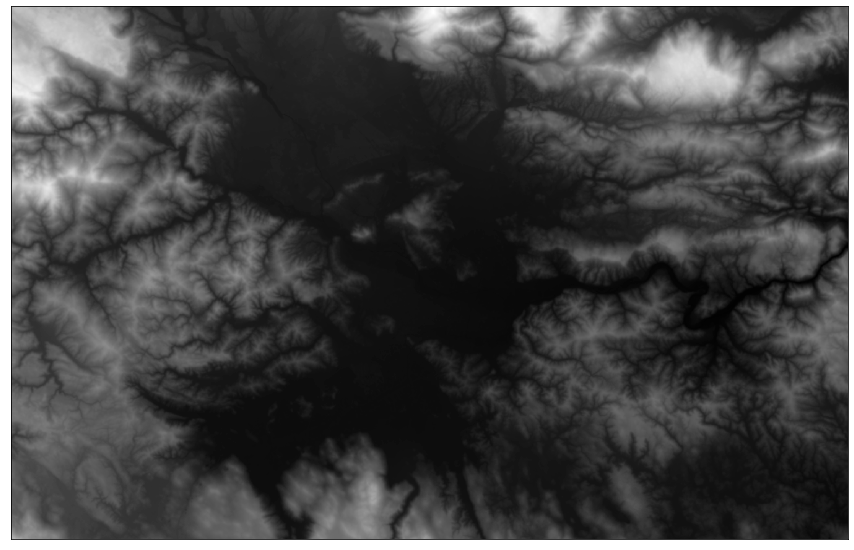

In [56]:
evalscript_dem = '''
//VERSION=3
function setup() {
  return {
    input: ["DEM"],

    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
'''

dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=('2020-06-12', '2020-06-13'),
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

dem_data = dem_request.get_data()

# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
print(dem_data[0])
#print(dem_data[1])
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=np.amin(dem_data[0]), vmax=np.amax(dem_data[0]))
data = dem_data[0]




In [34]:
# set ranges
betsiboka_coords_wgs84
t_data = np.transpose(data)

start_point = betsiboka_coords_wgs84[0:2]
end_point = betsiboka_coords_wgs84[2:4]

x_len = start_point[0] - end_point[0]
y_len = start_point[1] - end_point[1]

x_space = np.linspace(start_point[0], end_point[0], t_data.shape[0])
y_space = np.linspace(start_point[1], end_point[1], t_data.shape[1])



array([15.        , 14.99728261, 14.99456522, 14.99184783, 14.98913043,
       14.98641304, 14.98369565, 14.98097826, 14.97826087, 14.97554348,
       14.97282609, 14.9701087 , 14.9673913 , 14.96467391, 14.96195652,
       14.95923913, 14.95652174, 14.95380435, 14.95108696, 14.94836957,
       14.94565217, 14.94293478, 14.94021739, 14.9375    , 14.93478261,
       14.93206522, 14.92934783, 14.92663043, 14.92391304, 14.92119565,
       14.91847826, 14.91576087, 14.91304348, 14.91032609, 14.9076087 ,
       14.9048913 , 14.90217391, 14.89945652, 14.89673913, 14.89402174,
       14.89130435, 14.88858696, 14.88586957, 14.88315217, 14.88043478,
       14.87771739, 14.875     , 14.87228261, 14.86956522, 14.86684783,
       14.86413043, 14.86141304, 14.85869565, 14.85597826, 14.85326087,
       14.85054348, 14.84782609, 14.8451087 , 14.8423913 , 14.83967391,
       14.83695652, 14.83423913, 14.83152174, 14.82880435, 14.82608696,
       14.82336957, 14.82065217, 14.81793478, 14.81521739, 14.81

In [35]:
new_data = list(map(lambda x: list(map(lambda y: (y,False),x)) ,t_data))

In [63]:

data
# x y 
#data[0][0] 

new_data = list(map(lambda x: list(map(lambda y: (y,False),x)) ,data))

In [93]:

sel_x = 155
sel_y = 200

test = [[0,0,1,0,2,0],[0,0,0,0,0,0]]

#test =list(map(lambda x: list(map(lambda y: (y,False),x)) ,data))

list(map(list, zip(*test)))


[[0, 0], [0, 0], [1, 0], [0, 0], [2, 0], [0, 0]]

In [4]:
def find_closest(data, x, y, amount_x, amount_y, amount_z):
    final_array = []
    
    curr_x = x + amount_x
    curr_y = y + amount_y
    curr_z = data[curr_x][curr_y] 
    print(curr_x, curr_y, curr_z)
    while True:
        if curr_x > len(data) or curr_y > len(data[0]):
            return None
        calculated_z = data[curr_x][curr_y]
        if abs(calculated_z - curr_z) < 1:
            return (curr_x, curr_y)
        else:
            curr_x += amount_x
            curr_y += amount_y
            curr_z += amount_z     
        
find_closest(test, x=0,y=0, amount_x=110, amount_y=20, amount_z=100)

  

NameError: name 'test' is not defined

In [108]:
def build_ray_arree(data, x, y, amount_x, amount_y):
    final_array = []
    data = np.array(list(map(list, zip(*data))))
    curr_x = x 
    curr_y = y
    while True:
        if curr_x >= len(data) or curr_y >= len(data[0]) or curr_x < 0 or curr_y < 0:
            return final_array
        
        final_array.append(data[curr_x][curr_y])
        curr_x += amount_x
        curr_y += amount_y

build_ray_arree(test, x=0,y=0, amount_x=0, amount_y=1)




[0, 0]

In [131]:
z = np.array([100,70,30,20,60,80,90,100,120,40,20,145,170])


#is_left(np.array([0,100]),np.array([1,70]),np.array([2,30]))


array([[  0, 100],
       [  1,  70],
       [  2,  30],
       [  3,  20],
       [  4,  60],
       [  5,  80],
       [  6,  90],
       [  7, 100],
       [  8, 120],
       [  9,  40],
       [ 10,  20],
       [ 11, 145],
       [ 12, 170]])

In [138]:
def direction(p1, p2, p3):
      return np.cross(p3 - p1, p2 - p1)
    
def is_left(p1, p2, p3):
    return direction(p1, p2, p3) < 0


def seeable_points(arr):
    arr = np.array(list(zip(np.arange(len(arr)),arr)))
    print(arr)
    start = arr[0]
    middle = arr[1]
    
    final_arr = list()
    final_arr.append(True)
    final_arr.append(True)
    
    
    for element in arr[2:]:
        if is_left(start,middle,element):
            middle = element
            final_arr.append(True)
        else:
            final_arr.append(False)
    
    return np.array(final_arr)


[100  70  30  20  60  80  90 100 120  40  20 145 170]
[[  0 100]
 [  1  70]
 [  2  30]
 [  3  20]
 [  4  60]
 [  5  80]
 [  6  90]
 [  7 100]
 [  8 120]
 [  9  40]
 [ 10  20]
 [ 11 145]
 [ 12 170]]


array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True])

In [113]:
np.array((1,1)) - np.array((2,3))

array([-1, -2])

In [ ]:
for x in range(len(data)):
    for y in range(len(data[0]))
        
    

In [72]:
plt.imsave('fig.png', img)